<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Israel Rodríguez
- Nombre de alumno 2: Benjamín Torrealba


### **Link de repositorio de GitHub:** https://github.com/BnjmnNicholas/MDS7202-2023-2

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [164]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


In [165]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import  DummyClassifier
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_absolute_error, classification_report 
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import joblib

## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?. 

In [166]:
df.columns

Index(['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP', 'Diabetes'],
      dtype='object')

In [167]:
def categorical(df):
    """
    Returns categorical columns from the dataframe
    """
    categorical_columns = []
    for col in df.columns:
        if df[col].dtype == 'object':
            categorical_columns.append(col)
    return categorical_columns

In [168]:
categorical(df)

[]

In [169]:
# Split Data

train, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

X_train = train.drop(columns=['Diabetes'])
y_train = train['Diabetes']

X_val = val.drop(columns=['Diabetes'])
y_val = val['Diabetes']

X_test = test.drop(columns=['Diabetes'])
y_test = test['Diabetes']

In [170]:
columns_preprocessing = X_train.columns.to_list()

In [171]:
# Preprocessing

# Creamos el ColumnTransformer que procesa los datos numericos y categoricos
preprossesor = ColumnTransformer([
    ('numerical', MinMaxScaler(), columns_preprocessing)
])

preprossesor

ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                 ['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI',
                                  'Smoker', 'HeartDiseaseorAttack',
                                  'PhysActivity', 'Fruits', 'Veggies',
                                  'HvyAlcoholConsump', 'GenHlth', 'MentHlth',
                                  'PhysHlth', 'DiffWalk', 'Stroke',
                                  'HighBP'])])

In [172]:
# Pipeline XGBoost

pipeline_xgb = Pipeline([
        ('preprossesor', preprossesor),
        ('classifier', XGBClassifier(random_state=42, feature_name=columns_preprocessing))
])
pipeline_xgb

Pipeline(steps=[('preprossesor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['Age', 'Sex', 'HighChol',
                                                   'CholCheck', 'BMI', 'Smoker',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'GenHlth', 'MentHlth',
                                                   'PhysHlth', 'DiffWalk',
                                                   'Stroke', 'HighBP'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbac...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [173]:
# XGB train

pipeline_xgb.fit(X = X_train, y=y_train)
val_predictions_xgb = pipeline_xgb.predict(X_val)

# classification_report
print(classification_report(y_val, val_predictions_xgb))

[21:34:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_name" } are not used.



              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      6239
         1.0       0.74      0.78      0.76      6486

    accuracy                           0.75     12725
   macro avg       0.75      0.75      0.75     12725
weighted avg       0.75      0.75      0.75     12725



In [174]:
# Dummy classifier (only for baseline comparison)

pipeline_dummy = Pipeline([
        ('preprossesor', preprossesor),
        ('classifier', DummyClassifier())
])

pipeline_dummy.fit(X = X_train, y=y_train)
val_predictions_dummy = pipeline_dummy.predict(X_val)
# classification_report
print(classification_report(y_val, val_predictions_dummy))

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66      6239
         1.0       0.00      0.00      0.00      6486

    accuracy                           0.49     12725
   macro avg       0.25      0.50      0.33     12725
weighted avg       0.24      0.49      0.32     12725



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### Comentarios:



## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

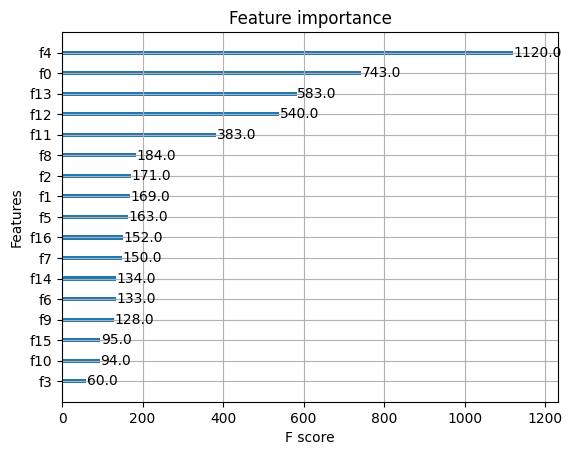

In [175]:
# Calcula la importancia de las features con el modelo entrenado (weight)

plot_importance(pipeline_xgb['classifier'], importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

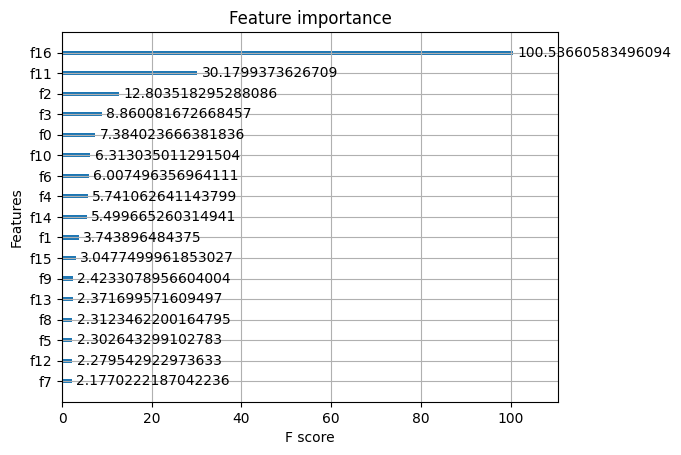

In [176]:
plot_importance(pipeline_xgb['classifier'], importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

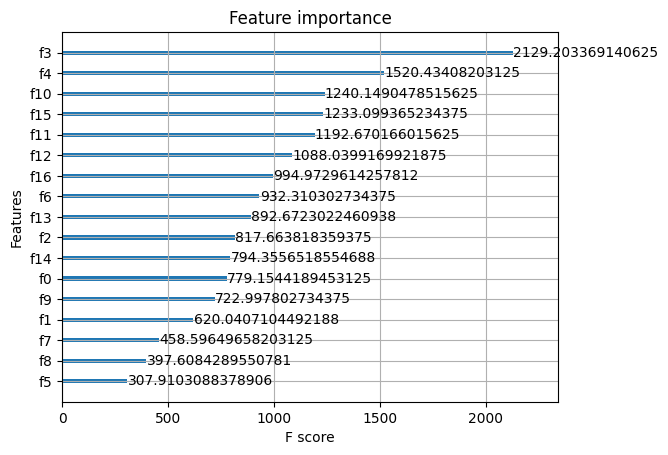

In [177]:
plot_importance(pipeline_xgb['classifier'], importance_type='cover')

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [178]:
result = permutation_importance(pipeline_xgb['classifier'], X_test, y_test, n_repeats=10, random_state=42)

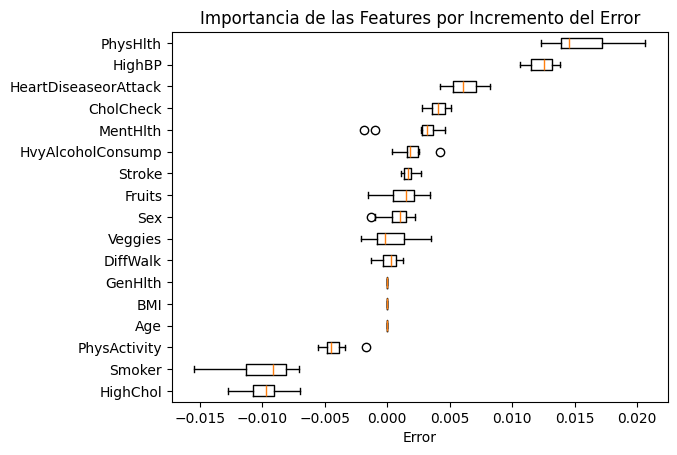

In [179]:
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(columns_preprocessing)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [180]:
#!pip install shap

In [181]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [182]:
import shap

In [183]:
# Inserte código para calcular shapley values aquí
explainer = shap.TreeExplainer(pipeline_xgb['classifier'])
shap_values = explainer(X_train)

[21:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [184]:
shap_values

.values =
array([[-0.06666017, -0.12586199,  0.17276827, ..., -0.25811443,
        -0.03079482,  0.52931243],
       [ 0.36378103, -0.08366421,  0.18411313, ...,  0.02656455,
        -0.01090183, -0.68073505],
       [ 0.02247164, -0.12496373,  0.10273028, ..., -0.16145085,
        -0.01748495,  0.6149581 ],
       ...,
       [ 0.37485895,  0.12626612,  0.14024621, ...,  0.03019161,
        -0.00889393,  0.49401835],
       [ 0.3401848 , -0.04423827, -0.27404198, ..., -0.14335448,
        -0.02586924,  0.4676353 ],
       [ 0.4965626 , -0.08656764, -0.18539438, ...,  0.05941055,
         0.01102423,  0.469902  ]], dtype=float32)

.base_values =
array([-0.01295933, -0.01295933, -0.01295933, ..., -0.01295933,
       -0.01295933, -0.01295933], dtype=float32)

.data =
array([[ 6.,  0.,  1., ...,  0.,  0.,  1.],
       [10.,  0.,  1., ...,  0.,  0.,  0.],
       [ 8.,  0.,  1., ...,  0.,  0.,  1.],
       ...,
       [ 9.,  1.,  1., ...,  0.,  0.,  1.],
       [10.,  0.,  0., ...,  0.,  0.

#### Respuestas a las preguntas:

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

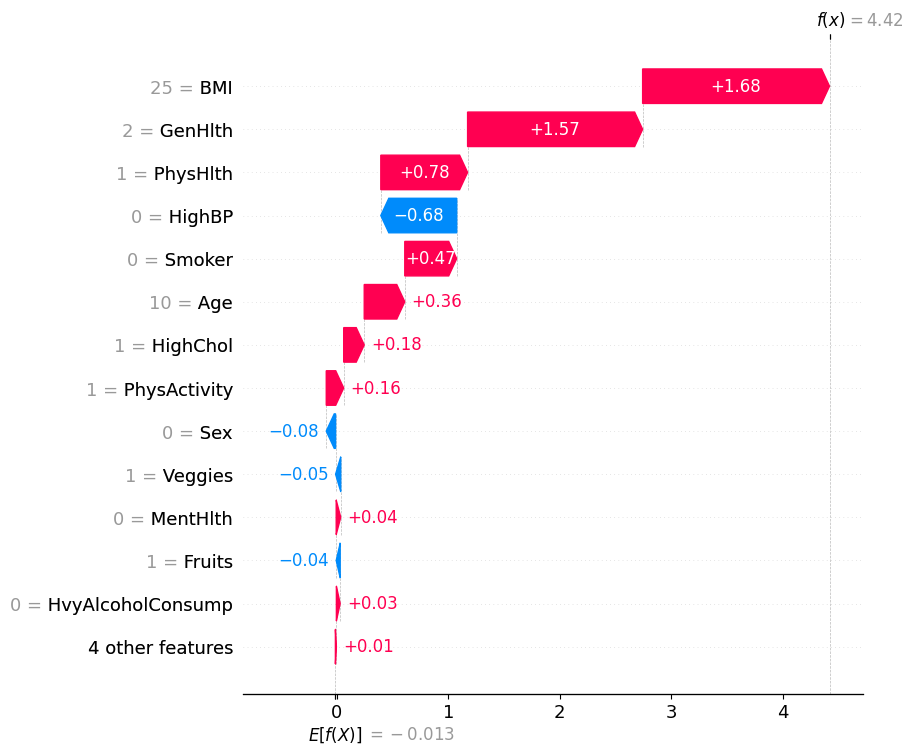

In [185]:
# Inserte código para generar gráficos de aporte local aquí
idx=1
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

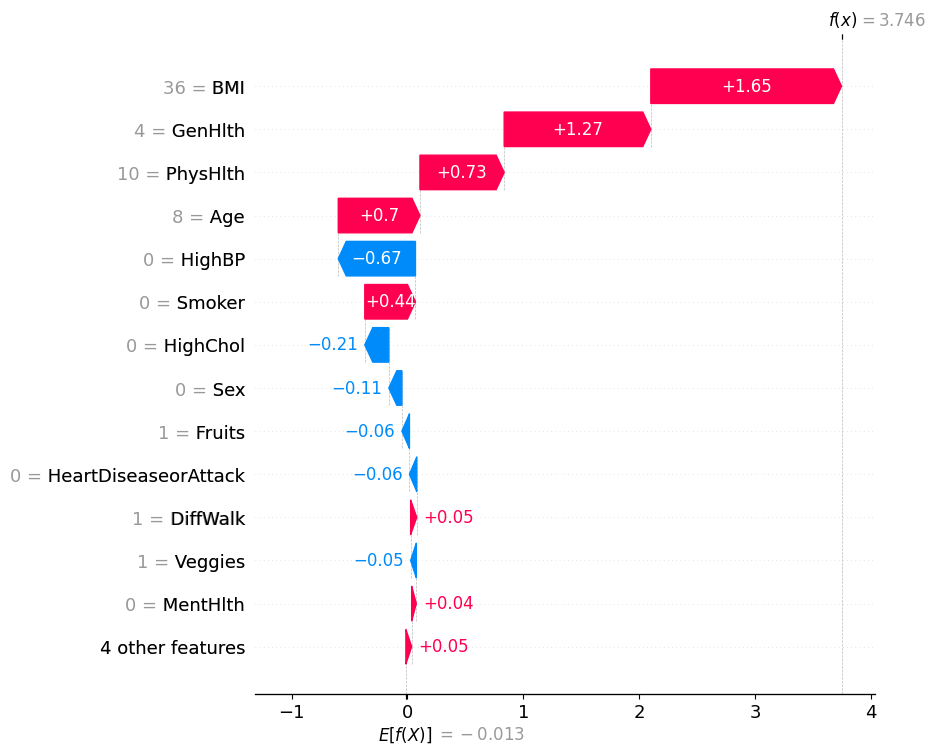

In [186]:
idx=9
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

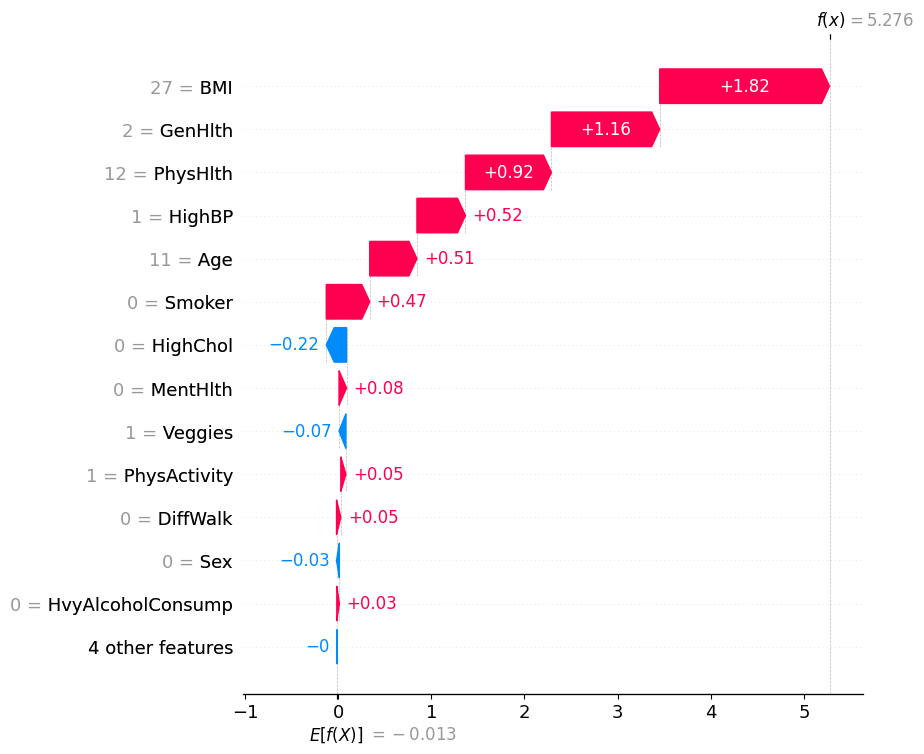

In [187]:
idx=150
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

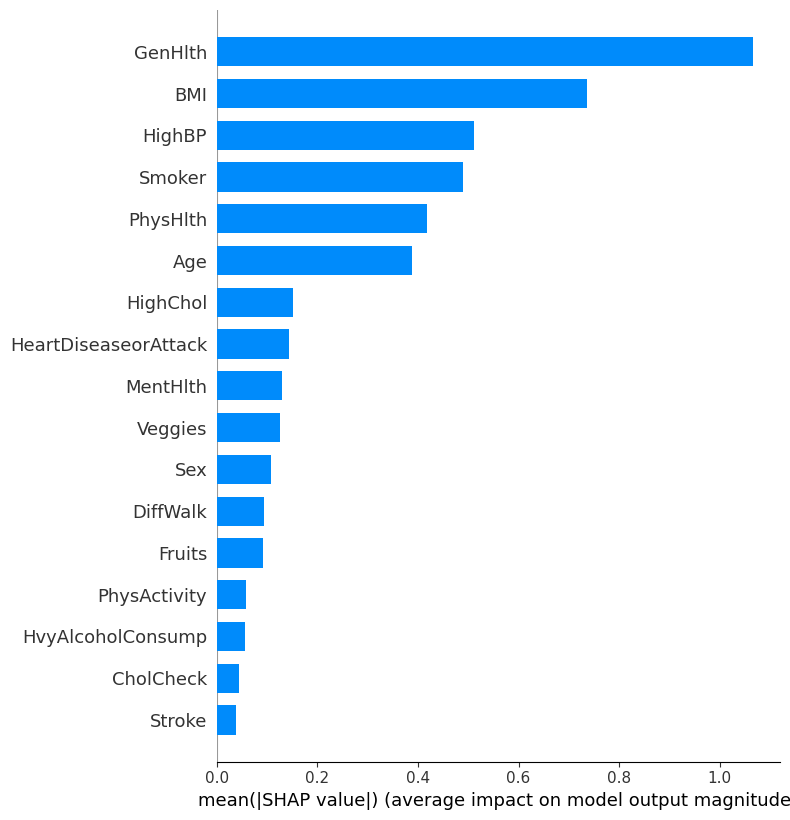

In [188]:
# Inserte código para generar gráficos de aporte global aquí
shap.summary_plot(shap_values, X_train, plot_type="bar")

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

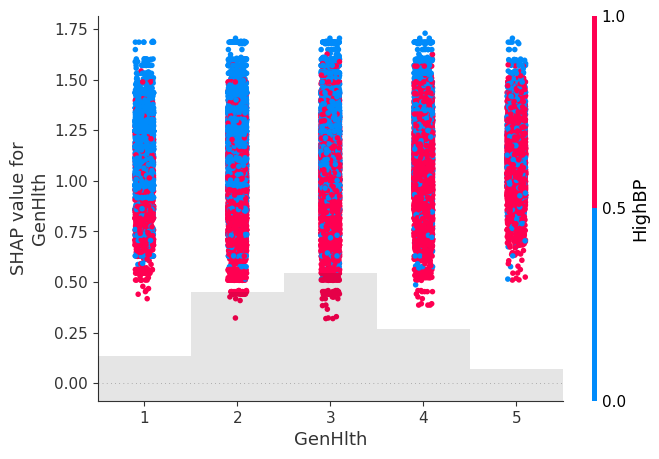

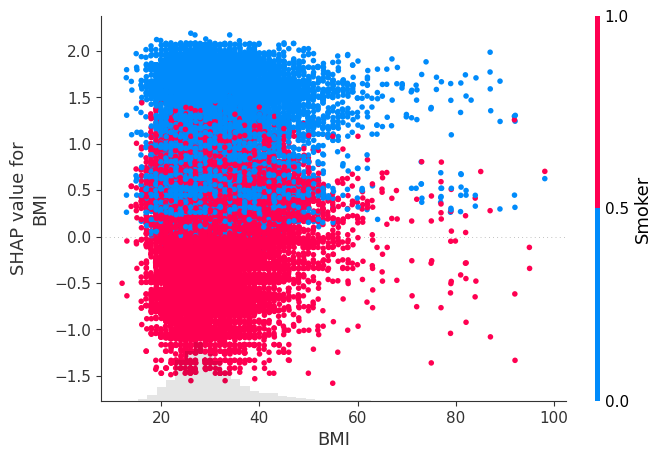

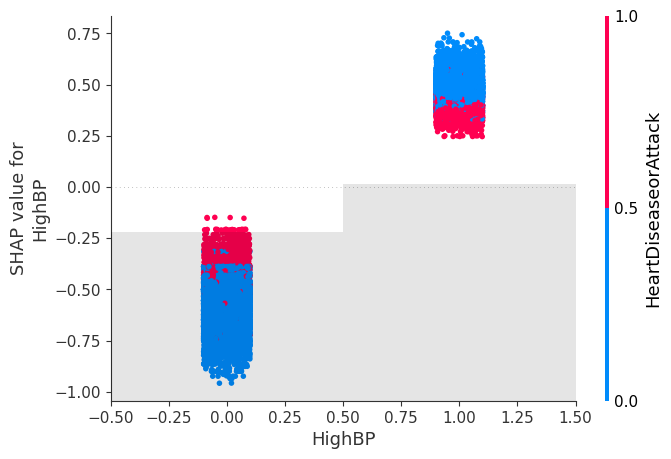

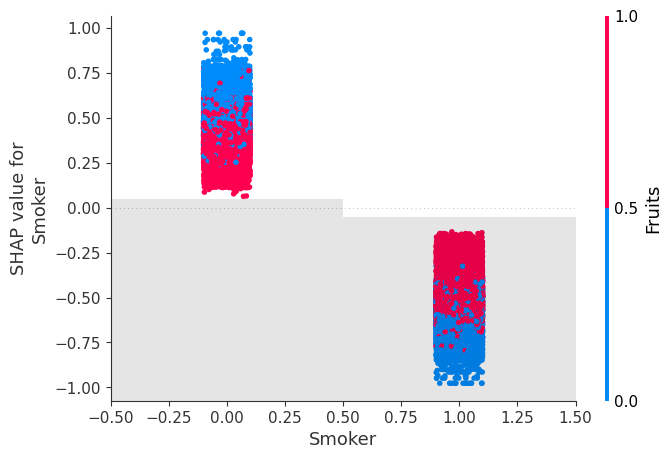

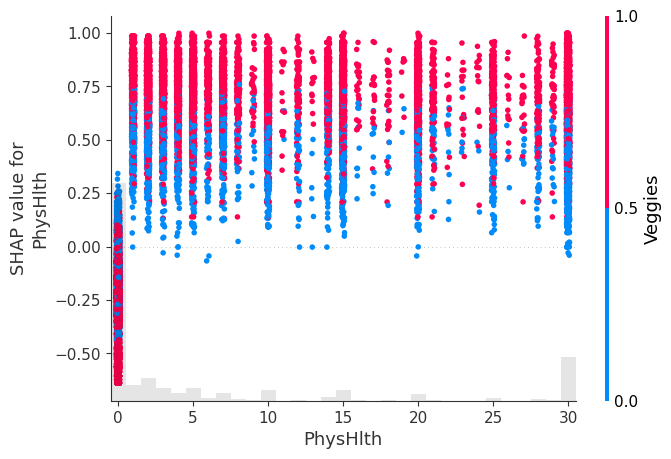

In [189]:
# Inserte código para generar gráficos de feature vs shap value aquí
# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

# Graficamos un scatterplot enre los shap values y las primeras 5 features con mayor impacto global
for name in feature_importance_names[:5]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name], 
                   color=shap_values)

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

TypeError: Axes.stem() got an unexpected keyword argument 'use_line_collection'

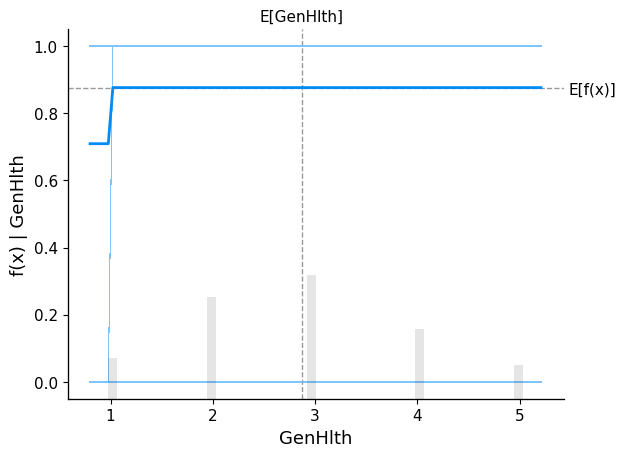

In [190]:
# Inserte código para generar gráficos PDP aquí
X1000 = shap.utils.sample(X_train, 1000)

sample_ind = 20
for name in feature_importance_names[:5]:
    shap.partial_dependence_plot(
        name, pipeline_xgb['classifier'].predict, X1000, model_expected_value=True,
        feature_expected_value=True, ice=True,
        shap_values=shap_values[sample_ind:sample_ind+1,:]
    )

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
#!pip install alibi

^C


  Using cached alibi-0.9.4-py3-none-any.whl (524 kB)
  Using cached spacy-3.7.2-cp311-cp311-win_amd64.whl (12.1 MB)
  Using cached blis-0.7.11-cp311-cp311-win_amd64.whl (6.6 MB)
  Using cached scikit_image-0.21.0-cp311-cp311-win_amd64.whl (22.8 MB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached dill-0.3.7-py3-none-any.whl (115 kB)
  Using cached transformers-4.35.2-py3-none-any.whl (7.9 MB)
  Using cached charset_normalizer-3.3.2-cp311-cp311-win_amd64.whl (99 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached certifi-2023.11.17-py3-none-any.whl (162 kB)
  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
  Using cached murmurhash-1.0.10-cp311-cp311-win_amd64.whl (25 kB)
  Using cached preshed-3.0.9-cp311-cp311-win_amd64.whl (122 kB)
  Using cached thinc-8.2.1-cp311-cp311-win_amd64.whl (1.5 MB)
  Using cached srsly-2.4.8-cp311-cp311-win_amd64.whl (479 kB)
  Using cached catalogue-2.0.10


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from alibi.explainers.anchors.anchor_tabular import AnchorTabular

In [ ]:
# Inserte su código para generar sistema de reglas aquí
predict_fn = lambda x: pipeline_xgb['classifier'].predict(x)
explainer = AnchorTabular(predict_fn, X_train.columns, seed=1)
explainer.fit(X_train.to_numpy())

class_names = ['No Diabetes', 'Diabetes']

idx = 1000
# explicar predicción idx 1000
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.9)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])


Prediction:  Diabetes


In [ ]:
# Inserte su código para generar sistema de reglas aquí
predict_fn = lambda x: pipeline_xgb['classifier'].predict(x)
explainer = AnchorTabular(predict_fn, X_train.columns, seed=1)
explainer.fit(X_train.to_numpy())

class_names = ['No Diabetes', 'Diabetes']

idx = 1000
# explicar predicción idx 1000
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.9)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print('\n')


idx = 3001
# explicar predicción idx 3001
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.9)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print('\n')

idx = 5751
# explicar predicción idx 5751
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.9)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  Diabetes
Anchor: Fruits > 0.00
Precision: 0.95
Coverage: 0.61


Prediction:  No Diabetes
Anchor: Smoker > 0.00 AND PhysHlth <= 0.00 AND MentHlth > 0.00 AND Age <= 7.00
Precision: 0.96
Coverage: 0.02


Prediction:  No Diabetes
Anchor: Smoker > 0.00 AND PhysHlth <= 0.00 AND Fruits <= 0.00 AND HighChol > 0.00 AND HighBP <= 0.00
Precision: 0.93
Coverage: 0.01


# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>